In [1]:
import os
import zipfile
import datetime
from collections import Counter

import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Add, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy

import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import pydot
from tensorflow.python.client import device_lib
import pathlib
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import random
import importlib

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
"""Data Augmentation"""
train_data_gen = ImageDataGenerator(rescale=1./255 ,
                                    zoom_range= 0.3, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    rotation_range = 30
                                    )

train = train_data_gen.flow_from_directory(directory= '../datasets/based_dataset/Train',
                                           class_mode = 'categorical',
                                           batch_size=64,
                                           target_size=(224,224))

Found 11825 images belonging to 3 classes.


In [4]:
test_data_gen = ImageDataGenerator(rescale=1./255 )

test = test_data_gen.flow_from_directory(directory= '../datasets/based_dataset/Test' , 
                                          target_size=(224,224), 
                                            class_mode = 'categorical',
                                        shuffle=False,
                                        batch_size=64)

valid = test_data_gen.flow_from_directory(directory= '../datasets/based_dataset/Valid' , 
                                          target_size=(224,224), 
                                            class_mode = 'categorical',
                                        shuffle=False,
                                        batch_size=64)

Found 3698 images belonging to 3 classes.
Found 2956 images belonging to 3 classes.


In [5]:
basenet = keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet',input_shape = (224,224,3))

In [6]:
for layer in basenet.layers:           
    layer.trainable = False

In [7]:
x = Flatten()(basenet.output)
d1 = Dense(1024, activation= 'relu')(x)
dr1 = Dropout(0.3)(d1)
d2 = Dense(1024, activation= 'relu')(dr1)
dr2 = Dropout(0.3)(d2)
prediction= Dense(units=3 , activation='softmax')(dr2)

model = Model(basenet.input,prediction)

In [8]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [9]:
early = EarlyStopping(monitor='accuracy',patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [10]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.7033995966580235, 1: 1.0246079195910234, 2: 0.695915725047081}


C:\Users\amara\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [11]:
hist = model.fit(train, steps_per_epoch= len(train), epochs= 50, validation_data= valid,class_weight=cw,validation_steps= len(test), callbacks=callbacks_list)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
185/185 [==============================] - 296s 1s/step - loss: 2.5557 - accuracy: 0.6679 - val_loss: 0.5590 - val_accuracy: 0.8024
Epoch 2/50
185/185 [==============================] - 220s 1s/step - loss: 0.7017 - accuracy: 0.7438
Epoch 3/50
185/185 [==============================] - 220s 1s/step - loss: 0.6625 - accuracy: 0.7658
Epoch 4/50
185/185 [==============================] - 212s 1s/step - loss: 0.6281 - accuracy: 0.7745
Epoch 5/50
185/185 [==============================] - 210s 1s/step - loss: 0.6359 - accuracy: 0.7449
Epoch 6/50
185/185 [==============================] - 202s 1s/step - loss: 0.6230 - accuracy: 0.7305

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/50
185/185 [==============================] - 198s 1s/step - loss: 0.5537 - accuracy: 0.8080
Epoch 8/50
185/185 [============

In [13]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

58/58 [==============================] - 56s 970ms/step - loss: 0.3656 - accuracy: 0.8759
The testing accuracy is : 87.58788704872131 %


In [ ]:
#model.save('dense121_normal_covid_lungOpacity')

In [14]:
pred = model.predict(test,verbose=1)

58/58 [==============================] - 47s 798ms/step


In [15]:
prediction = pred.copy

In [16]:
predictions = np.argmax(pred, axis = -1)

In [17]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','COVID', 'Lung Opacity']))

              precision    recall  f1-score   support

      NORMAL       0.85      0.80      0.83       724
       COVID       0.86      0.88      0.87      1203
Lung Opacity       0.89      0.90      0.90      1771

    accuracy                           0.88      3698
   macro avg       0.87      0.86      0.87      3698
weighted avg       0.88      0.88      0.88      3698



In [18]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import seaborn as sns

In [19]:
y_true=test.classes

**Overall Results**
Accuracy Result: 87.59%
Precision Result: 86.12%
Recall Result: 88.20%
F-Score Result: 87.15%


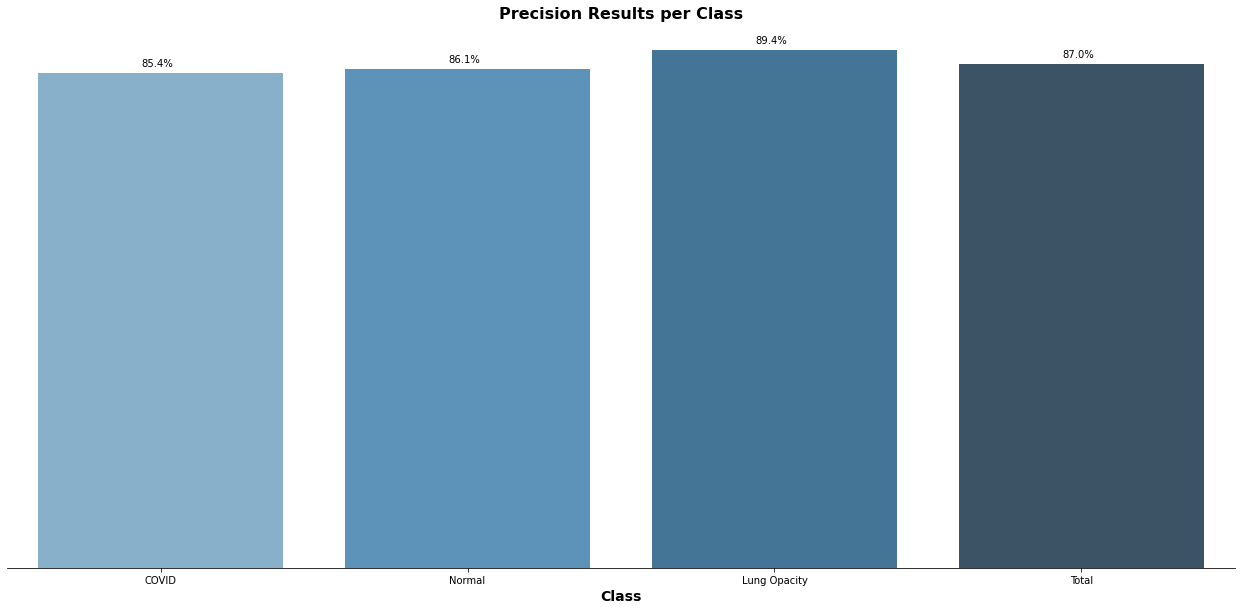

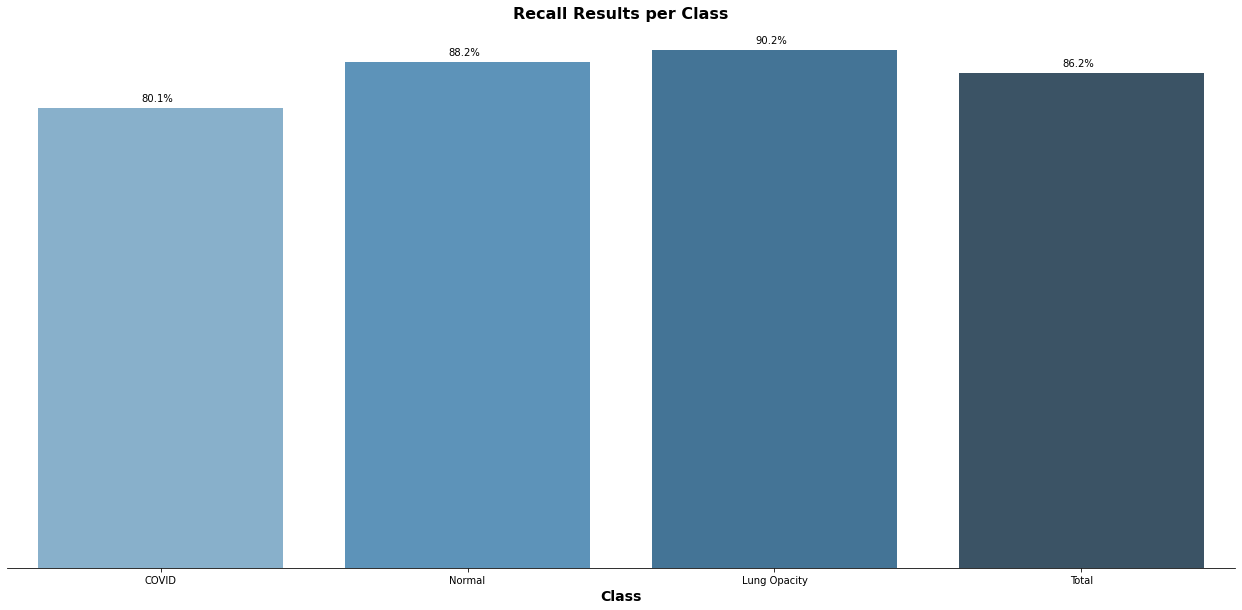

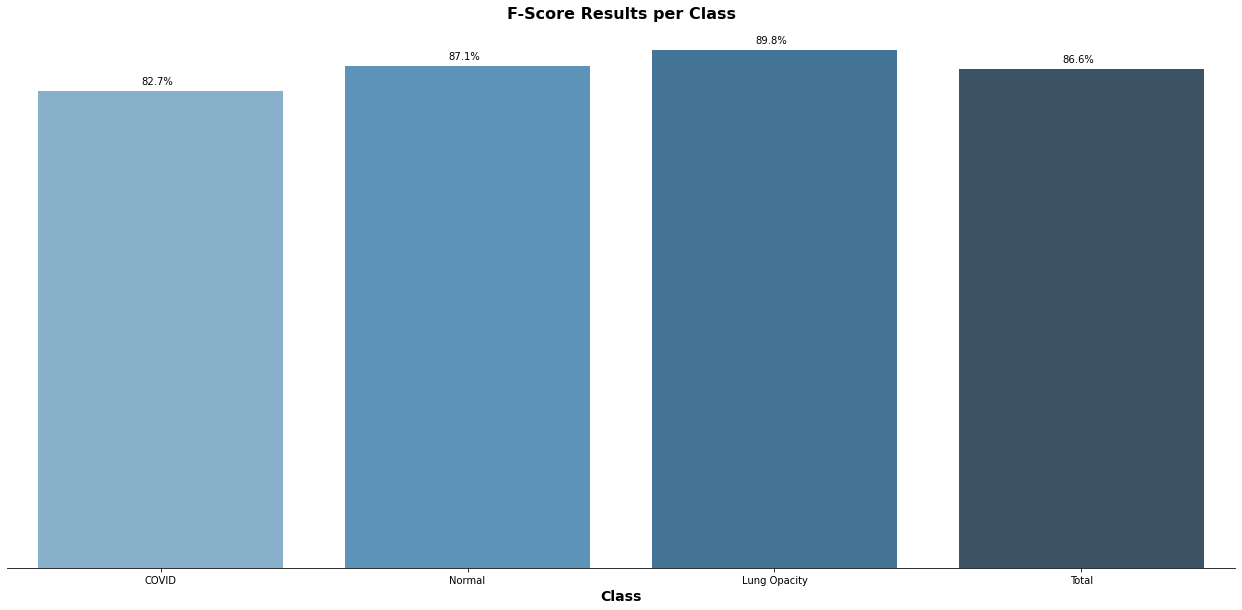

In [20]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID','Normal','Lung Opacity','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[1,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[1,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[1,2]*100))#F-Score of the whole Dataset

<AxesSubplot:>

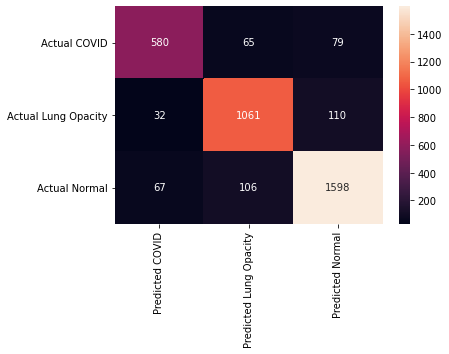

In [21]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions),index=["Actual COVID", "Actual Lung Opacity", "Actual Normal"],
columns=["Predicted COVID", "Predicted Lung Opacity","Predicted Normal"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

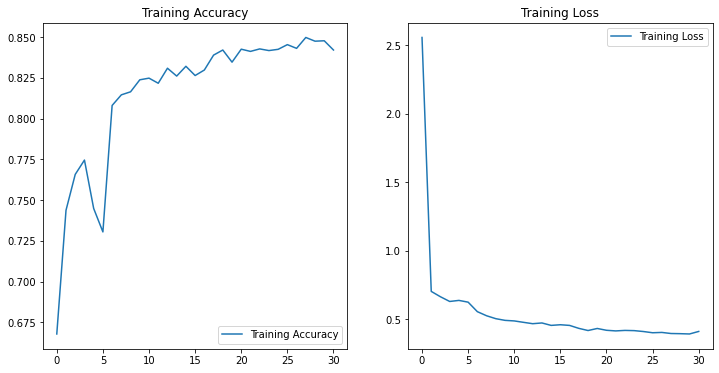

In [22]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(31)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')

plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')

plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()